# Market Timing Algorithm

## 1 - Context and Theory

Key principle: There is long run growth in stock returns, which has predictive power such that: 
- When price is significantly above the trend line, it is a sell opportunity
- When price is significantly below trend, it is a buy opportunity

A number of things need to be discovered:
- Optimum trend line
- Optimimum timing threshold
- Optimum sell-off weight

Link
- https://pandas.pydata.org/pandas-docs/version/1.2.3/getting_started/intro_tutorials/09_timeseries.html
- https://pandas.pydata.org/docs/user_guide/indexing.html
- http://www.kasimte.com/2020/02/09/linear-regression-from-time-series-data-using-scikit-learn.html
- https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
- https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series/tutorial

#### 1.1 - Optimum Trend Line
Several options here, from full-on machine learning models, to factor regressions, to straight line rules. We want to first focus on the simplest ideas.

For a trendline to be practible, it needs to:
- Regularly and meaningfully deviate from price

***Ideas***
- CAGR
- Simple regression

#### 1.2 - To Dos

***Deeper Study of CAGR relation to historical returns***
Overlay plot of year-on-year returns  (or longer?) with price charts and see what the periods of greatest longer term return looks like
- Idea: Add coloured bands when CAGR is 
- Use standard error instead of percentiles

In [1]:
# For reading stock data from yahoo
#from pandas_datareader.data import DataReader
#import yfinance as yf

## 2 - Creating Infrastructure and Dataset

#### 2.1 - Imports

In [2]:
import os
import pandas as pd 
import numpy as np 
import matplotlib as plt 
import seaborn as sns    #not required until graphing
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
sns.set_style("white")
sns.set_palette("deep")

#### 2.2 - Fixing the Directory

In [3]:
env = os.chdir(r'C:\Users\alexb\OneDrive\Documents\02 - Work\coding\TimeSeries')
path = os.getcwd()
path

'C:\\Users\\alexb\\OneDrive\\Documents\\02 - Work\\coding\\TimeSeries'

In [4]:
%%html 
<style>
table {float:left}
</style>

#### 2.3 - Downloading and Cleaning the data
In our case, data comes from: https://www.kaggle.com/datasets/pdquant/sp500-daily-19862018?resource=download
- *Frequency*: Daily, excluding weekends
- *Start year*: 2-January-1986
- *End year*: 29-Jun-18
- *Number of periods*: 8192

***Descriptive Statistics***

| Metric      | Value       |   | Metric      | Value       |
| ----------- | ----------- |   |-------------|-------------|
| Frequency   | Daily (B)   |   | Count       | 8192        |
| Start Year  | 02-Jan-1986 |   | Mean        | 1070        |
| End Year    | 29-Jun-2018 |   | Max         | 2872        | 
| Periods     | 8192        |   | StD         | 616         |

In [5]:
df1 = pd.read_csv("spx.csv", infer_datetime_format = True)

#----------Testing-------------#
#print(df1.describe())
#df1.head(3)

In [6]:
df1['date'] = pd.to_datetime(df1['date'])    #Uncomment everytime you rerun
#df1.set_index('date', inplace=True)

#----------Testing-------------#
df1.head(3)

,date,close
0,1986-01-02,209.59
1,1986-01-03,210.88
2,1986-01-06,210.65


#### 2.4 - A First Look

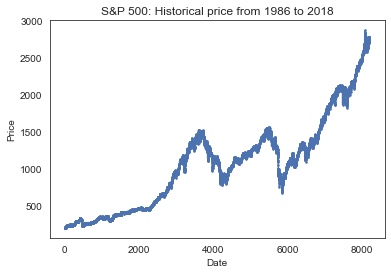

In [7]:
plt.plot(df1["close"], marker="o", ms=1.5)

# Labelling 

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("S&P 500: Historical price from 1986 to 2018")

#plt.xlim([datetime.date(1886, 1, 1), datetime.date(2018, 1, 1)])
#plt.ylim(-20,20)

plt.show()

Looks good - let's see how it looks when we add the inflation data

## 3 - Adjusting for Inflation

Given the length of our timeseries we have to adjust for inflation. To do this we use the CPI to benchmark our price data.

Theory: https://people.duke.edu/~rnau/411infla.htm
- *Source*: https://data.bls.gov/
- *Series Title*: All items in U.S. city average, all urban consumers, not seasonally adjusted
- *Area*: U.S. city average
- *Base Period*:  1982-84=100

Current problem: Monthly data to daily
(Note - highlights where returns are supernormal or super abnormal)

#### 3.1 - Importing Dataset

In [8]:
cpi = pd.read_csv("cpi.csv", infer_datetime_format = True)
#cpi.head(4)

In [9]:
cpi['Date'] = pd.to_datetime(cpi['Date'], format='%d-%m-%Y')
#cpi.set_index('Date', inplace=True)

cpi.head(3)

#result = cpi.dtypes
#result


,Date,Price
0,1986-01-01,109.6
1,1986-02-01,109.3
2,1986-03-01,108.8


#### 3.2 - Merging CPI data with price data
Strategy:
- Create list of month_year combinations in CPI dataframe
- Create list of month_year combinations in S&P dataframe
- Merge value if they equal each other

In [10]:
cpi['month_year'] = cpi['Date'].dt.to_period('M')
cpi.head(5)

,Date,Price,month_year
0,1986-01-01,109.6,1986-01
1,1986-02-01,109.3,1986-02
2,1986-03-01,108.8,1986-03
3,1986-04-01,108.6,1986-04
4,1986-05-01,108.9,1986-05


In [11]:
df1['month_year'] = df1['date'].dt.to_period('M')
df1.head(5)

,date,close,month_year
0,1986-01-02,209.59,1986-01
1,1986-01-03,210.88,1986-01
2,1986-01-06,210.65,1986-01
3,1986-01-07,213.80,1986-01
4,1986-01-08,207.97,1986-01


In [115]:
date_list = pd.to_datetime(df1['date'])
print(date_list.head(6))

rows = len(date_list) 
rows      # to give us the number of times we need to run the loop

0   1986-01-02
1   1986-01-03
2   1986-01-06
3   1986-01-07
4   1986-01-08
5   1986-01-09
Name: date, dtype: datetime64[ns]


8192

0   1986-01-02
1   1986-01-03
2   1986-01-06
3   1986-01-07
4   1986-01-08
5   1986-01-09
Name: date, dtype: datetime64[ns]

In [13]:
sp_date = df1.iloc[3,2]
print(sp_date)

cpi_index = cpi[cpi['month_year']=='1986-05'].index.values
cpi_index = cpi_index[0]
print(cpi_index)

cpi_value = cpi.iloc[3,1]
print(cpi_value)

1986-01
4
108.6


In [117]:
temp_list = []
i = 0

for i in range(rows):
    sp_date = df1.iloc[i,2]
    cpi_index = cpi[cpi['month_year']==sp_date].index.values
    cpi_index = cpi_index[0]
    cpi_value = cpi.iloc[cpi_index,1]
    temp_list.append(cpi_value)
    
    i = i + 1

df1["cpi"] = temp_list

df1.tail(5)
    

IndexError: index 0 is out of bounds for axis 0 with size 0

In [15]:
df1['price'] = (df1['close'] / df1['cpi']) * 100
df1.head(5)

,date,close,month_year,cpi,price
0,1986-01-02,209.59,1986-01,109.6,191.231752
1,1986-01-03,210.88,1986-01,109.6,192.408759
2,1986-01-06,210.65,1986-01,109.6,192.198905
3,1986-01-07,213.80,1986-01,109.6,195.072993
4,1986-01-08,207.97,1986-01,109.6,189.753650


In [16]:
df1.drop('month_year', inplace=True, axis=1)
df1.head(5)

,date,close,cpi,price
0,1986-01-02,209.59,109.6,191.231752
1,1986-01-03,210.88,109.6,192.408759
2,1986-01-06,210.65,109.6,192.198905
3,1986-01-07,213.80,109.6,195.072993
4,1986-01-08,207.97,109.6,189.753650


***Current Issues***: Slight issues towards end of month as likely deviation from inflation start is greatest. Solutions might be to incrementally move towards end

#### 2.4 - Calculating Inflation

## 4 - Trendline 1: CAGR

***Goal***: Determine whether CAGR contains any information about future prices

Method:
- Create a function to predict prices based on CAGR from N periods ago to today
- Check data to find first 'reasonable' benchmark and test

#### 4.1 - Assumptions
We have daily data (in business days). How will we determine our decision window? A couple of ideas:

***CAGR Window*** - 15 years
***Decision Interval*** - Weekly



In [17]:
days_in_week = 5
weeks_in_year = 52
years_in_window = 15

bin_size = days_in_week*weeks_in_year*years_in_window
bin_size

3900

#### 4.2 - Creating list of start values
To calculate CAGR we want to know, at time t, what the CAGR should have gotten us if we started investing t-25 years ago

bin-size = 3900

In [18]:
start_values = []

i = 0

for i in range(rows):
    start_index = i - bin_size
    if start_index >= 0:
        dummy = df1.iloc[start_index,3]
        start_values.append(dummy)
        i = i + 1
    else:
        start_values.append(np.nan)
        i = i + 1

df1["start price"] = start_values
df1.head(3905)

,date,close,cpi,price,start price
0,1986-01-02,209.59,109.6,191.231752,NaN
1,1986-01-03,210.88,109.6,192.408759,NaN
2,1986-01-06,210.65,109.6,192.198905,NaN
3,1986-01-07,213.80,109.6,195.072993,NaN
4,1986-01-08,207.97,109.6,189.753650,NaN
...,...,...,...,...,...
3900,2001-06-08,1264.96,178.0,710.651685,191.231752
3901,2001-06-11,1254.39,178.0,704.713483,192.408759
3902,2001-06-12,1255.85,178.0,705.533708,192.198905
3903,2001-06-13,1241.60,178.0,697.528090,195.072993


#### 4.3 - Calculating CAGR

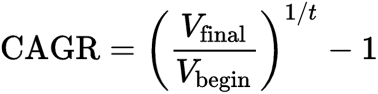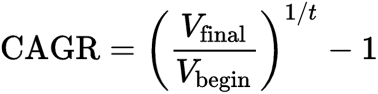

In [19]:
df1["cagr"] = (((df1["price"]/df1["start price"])**(1/years_in_window))-1)*100
#df1.set_index("date", inplace=True)

df1.head(3905)

,date,close,cpi,price,start price,cagr
0,1986-01-02,209.59,109.6,191.231752,NaN,NaN
1,1986-01-03,210.88,109.6,192.408759,NaN,NaN
2,1986-01-06,210.65,109.6,192.198905,NaN,NaN
3,1986-01-07,213.80,109.6,195.072993,NaN,NaN
4,1986-01-08,207.97,109.6,189.753650,NaN,NaN
...,...,...,...,...,...,...
3900,2001-06-08,1264.96,178.0,710.651685,191.231752,9.145655
3901,2001-06-11,1254.39,178.0,704.713483,192.408759,9.040002
3902,2001-06-12,1255.85,178.0,705.533708,192.198905,9.056392
3903,2001-06-13,1241.60,178.0,697.528090,195.072993,8.865675


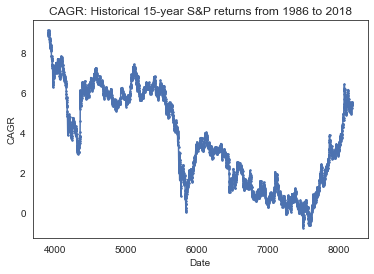

In [20]:
plt.plot(df1["cagr"], marker="o", ms=1.5)

# Labelling 

plt.xlabel("Date")
plt.ylabel("CAGR")
plt.title("CAGR: Historical 15-year S&P returns from 1986 to 2018")

#plt.xlim([datetime.date(1886, 1, 1), datetime.date(2018, 1, 1)])
#plt.ylim(-20,20)

plt.show()

#### 4.4 - Computing Predicted Value

In [21]:
def predict_value(cagr,start):
    cagr = cagr / 100
    predicted_value = start * ((1 + cagr)**years_in_window)
    
    return predicted_value


value = predict_value(9.146,191.232)
print(value)

710.6862790725751


In [22]:
predictions = []

i = 0

for i in range(rows):
    start = df1.iloc[i,4]
    cagr = df1.iloc[i,5]
    value = predict_value(cagr,start)
    predictions.append(value)
    i = i + 1
    
#print(predictions)
df1["15-year predictions"] = predictions
df1.head(3905)


,date,close,cpi,price,start price,cagr,15-year predictions
0,1986-01-02,209.59,109.6,191.231752,NaN,NaN,NaN
1,1986-01-03,210.88,109.6,192.408759,NaN,NaN,NaN
2,1986-01-06,210.65,109.6,192.198905,NaN,NaN,NaN
3,1986-01-07,213.80,109.6,195.072993,NaN,NaN,NaN
4,1986-01-08,207.97,109.6,189.753650,NaN,NaN,NaN
...,...,...,...,...,...,...,...
3900,2001-06-08,1264.96,178.0,710.651685,191.231752,9.145655,710.651685
3901,2001-06-11,1254.39,178.0,704.713483,192.408759,9.040002,704.713483
3902,2001-06-12,1255.85,178.0,705.533708,192.198905,9.056392,705.533708
3903,2001-06-13,1241.60,178.0,697.528090,195.072993,8.865675,697.528090


In [23]:
df1.iloc[3904,5]

8.938208103185952

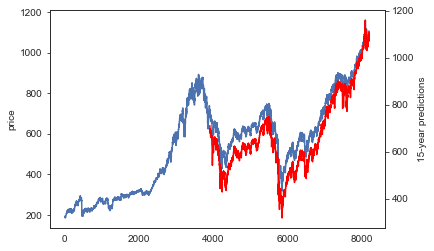

In [24]:
sns.lineplot(data=df1["price"])
ax2 = plt.twinx()
sns.lineplot(data=df1["15-year predictions"], color="r", ax=ax2)

plt.show()

Conclusion - Not a good signal for market timing. Idea: try fix CAGR somehow (for example by using the CAGR from 10 periods ago) to show how far you are deviating from that

Another idea: Theoretical perfect is selling everything high and rebuying everything low with perfect hindsight. This can be the comparer

## 5 - Trendline 2: Simple regression

#### 5.1 - Generating Days_from_Start variable
Will help us define number of years better.

In [25]:
#df1['days_from_start'] = (df1['date'] - df1.["date"][0]).days; df1

#df1.head()

In [26]:
exclusions = ["close","cpi","15-year predictions"]
i = 0
while i < len(exclusions):
    df1.drop(exclusions[i], inplace=True, axis=1)
    i = i + 1

df1.tail(6)

,date,price,start price,cagr
8186,2018-06-22,1093.254071,493.349917,5.447852
8187,2018-06-25,1078.249447,491.796573,5.372896
8188,2018-06-26,1080.626535,483.913765,5.501956
8189,2018-06-27,1071.328510,486.119403,5.409232
8190,2018-06-28,1077.947847,486.357103,5.449089
8191,2018-06-29,1078.765343,500.291690,5.256012


#### 5.2 - Creating function to isolate relevant cross-section

In [27]:
def temp_dataframe(i):
    start = i - bin_size
    end = i 
    temp_df = df1.iloc[start:end, 0:4]
    temp_df = pd.DataFrame(data=temp_df)
    return temp_df


a = temp_dataframe(4000)
a

,date,price,start price,cagr
100,1986-05-27,224.747475,NaN,NaN
101,1986-05-28,226.473829,NaN,NaN
102,1986-05-29,227.713499,NaN,NaN
103,1986-05-30,227.134986,NaN,NaN
104,1986-06-02,223.780822,NaN,NaN
...,...,...,...,...
3995,2001-10-29,606.809229,214.141414,7.190616
3996,2001-10-30,596.392797,216.813590,6.978473
3997,2001-10-31,596.387169,216.207530,6.998371
3998,2001-11-01,611.104848,220.495868,7.032175


#### 5.4 - Function to find i for a given datetime

In [28]:
analysis_year = "2000-01-10"
i = df1.index[df1["date"]==analysis_year]
i[0]

3544

#### 5.5 - First Regressions

In [29]:
# Calling the data
sample1 = temp_dataframe(4000)
sample1.tail(6)

,date,price,start price,cagr
3994,2001-10-26,621.615082,213.737374,7.376540
3995,2001-10-29,606.809229,214.141414,7.190616
3996,2001-10-30,596.392797,216.813590,6.978473
3997,2001-10-31,596.387169,216.207530,6.998371
3998,2001-11-01,611.104848,220.495868,7.032175
3999,2001-11-02,612.852311,221.625344,7.016094


In [30]:
#sample1['days_from_start'] = (sample1['date'] - sample1.["date"][0]).days
#sample1.tail(6)

sample1['time'] = np.arange(len(sample1.index))

sample1.head()

,date,price,start price,cagr,time
100,1986-05-27,224.747475,NaN,NaN,0
101,1986-05-28,226.473829,NaN,NaN,1
102,1986-05-29,227.713499,NaN,NaN,2
103,1986-05-30,227.134986,NaN,NaN,3
104,1986-06-02,223.780822,NaN,NaN,4


In [31]:
x = sample1['time'].values.reshape(-1, 1)
y = sample1['price'].values
#print(x)
#print(y)

In [32]:
regr = linear_model.LinearRegression()
regr.fit(x,y)

print(regr.coef_)
print(regr.intercept_)

m = regr.coef_
a = regr.intercept_
 

[0.16374778]
101.99499025098112


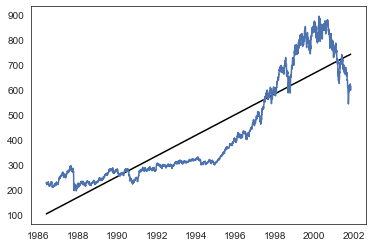

In [33]:
plt.plot(sample1['date'], regr.predict(x),color='black')
plt.plot(sample1['date'], y)

Looks good , but this would indidicate very few buy and sell decisions. It will be interesting to see how much this line changes through each step through window. 

Experiment: Loop through each bin, conduct the regression and return the slope . Or maybe even a tuple of intercept slope

Idea: Add interest rate and inflation 

Can we add CAGR somehow? Can we use CAGR to study when periods of high returns are? 

## 6 - Optimimum Threshold 1: Standard Error

We have the regression line, now we want to find a way to step through each bin, and have a buy or sell decision, alongside how much we sell at that point

Steps:
1. Create a function that steps to t+1, and runs a regression from [t-bin_size:t] and returns the predicted value for t+1
2. Create a tiered system where you set percentages to sell for each threshold
3. Create a function that has a wallet that buys and sells based on those tiers
4. Compare return to market return

Note, use function to:
1. Generate sample for index i
2. Treat sample
3. Run regression and predict t+1
4. Append  that to some list
Might have to make a dictionary to also draw standard error (as first theory for the threshold)

Give points to bands (0.5 if in 0.5 standard error range), points are cleared when reclrossing the line.

Need to reach a certain  number of points to reach a sell decision. Counter restarts when sell, but percentage bought or sold is increased if it happens consecutively

#### 6.1 - Analysing CAGR and historic returns

In [34]:
df1.head(3)

,date,price,start price,cagr
0,1986-01-02,191.231752,NaN,NaN
1,1986-01-03,192.408759,NaN,NaN
2,1986-01-06,192.198905,NaN,NaN


In [35]:
df1.tail(3)

,date,price,start price,cagr
8189,2018-06-27,1071.328510,486.119403,5.409232
8190,2018-06-28,1077.947847,486.357103,5.449089
8191,2018-06-29,1078.765343,500.291690,5.256012


(1988, 2020)

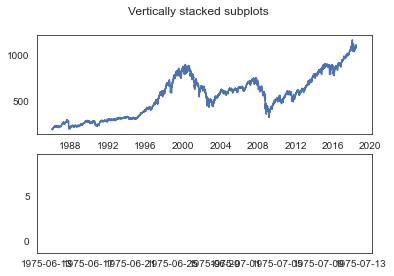

In [36]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df1['date'], df1['price'])
axs[1].plot(df1['date'], df1['cagr'])
axs[1].set_xlim(1988,2020)

(0.0, 8000.0)

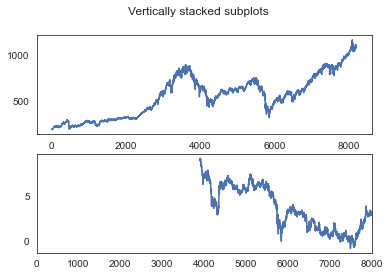

In [37]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df1.index.values, df1['price'])
axs[1].plot(df1.index.values, df1['cagr'])
axs[1].set_xlim(0,8000)

Note, you want 1-year return here

In [38]:
days_in_week = 5
weeks_in_year = 52
years_in_window = 1

bin_size = days_in_week*weeks_in_year*years_in_window
bin_size

260

In [39]:
start_values = []

i = 0

for i in range(rows):
    start_index = i - bin_size
    if start_index >= 0:
        dummy = df1.iloc[start_index,1]
        start_values.append(dummy)
        i = i + 1
    else:
        start_values.append(np.nan)
        i = i + 1

df1["price t-1yr"] = start_values
df1.head(265)

,date,price,start price,cagr,price t-1yr
0,1986-01-02,191.231752,NaN,NaN,NaN
1,1986-01-03,192.408759,NaN,NaN,NaN
2,1986-01-06,192.198905,NaN,NaN,NaN
3,1986-01-07,195.072993,NaN,NaN,NaN
4,1986-01-08,189.753650,NaN,NaN,NaN
...,...,...,...,...,...
260,1987-01-13,233.767986,NaN,NaN,191.231752
261,1987-01-14,236.187050,NaN,NaN,192.408759
262,1987-01-15,238.750000,NaN,NaN,192.198905
263,1987-01-16,239.460432,NaN,NaN,195.072993


In [40]:
df1["1-yr_cagr"] = ((df1["price"]/df1["price t-1yr"])-1)*100

df1.head(265)

,date,price,start price,cagr,price t-1yr,1-yr_cagr
0,1986-01-02,191.231752,NaN,NaN,NaN,NaN
1,1986-01-03,192.408759,NaN,NaN,NaN,NaN
2,1986-01-06,192.198905,NaN,NaN,NaN,NaN
3,1986-01-07,195.072993,NaN,NaN,NaN,NaN
4,1986-01-08,189.753650,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
260,1987-01-13,233.767986,NaN,NaN,191.231752,22.243290
261,1987-01-14,236.187050,NaN,NaN,192.408759,22.752754
262,1987-01-15,238.750000,NaN,NaN,192.198905,24.220271
263,1987-01-16,239.460432,NaN,NaN,195.072993,22.754272


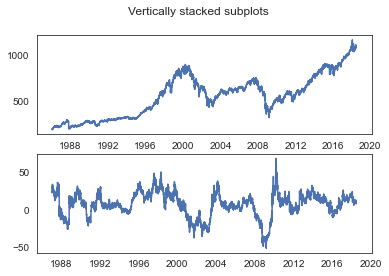

In [41]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(df1['date'], df1['price'])
axs[1].plot(df1['date'], df1['1-yr_cagr'])
#axs[1].set_xlim(0,8000)

#### 6.2 - Linear regression using statsmodels (to get standard error)

We'll be using a 10-year regression window in this case

In [73]:
days_in_week = 5
weeks_in_year = 52
years_in_window = 10

bin_size = days_in_week*weeks_in_year*years_in_window
bin_size

2600

In [80]:
sample2 = temp_dataframe(8000)
sample2['time'] = np.arange(len(sample2.index))
sample2.tail(6)

,date,price,start price,cagr,time
7994,2017-09-18,1014.455937,642.449664,3.092310,2594
7995,2017-09-19,1015.582269,633.036913,3.201436,2595
7996,2017-09-20,1016.226466,636.739374,3.165682,2596
7997,2017-09-21,1013.131080,640.145414,3.108025,2597
7998,2017-09-22,1013.787431,641.717002,3.095622,2598
7999,2017-09-25,1011.534768,637.675195,3.123763,2599


In [75]:
x = sample2['time'].values.reshape(-1, 1)
y = sample2['price'].values

In [76]:
mod = sm.OLS(x,y)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.550
Model:                            OLS   Adj. R-squared (uncentered):              0.550
Method:                 Least Squares   F-statistic:                              3174.
Date:                Sat, 18 Jun 2022   Prob (F-statistic):                        0.00
Time:                        15:59:35   Log-Likelihood:                         -19948.
No. Observations:                2600   AIC:                                  3.990e+04
Df Residuals:                    2599   BIC:                                  3.990e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9894      0.014    138.071      0.000       1.961       2.018
==============================================================================
Omnibus:                      317.697   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.937
Skew:                          -0.983   Prob(JB):                     1.79e-96
Kurtosis:                       3.452   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

NOt really sure how to use standard error. I think it means the coefficient can go up. I will use average residual sum of squares instead.  

In [46]:
regr = linear_model.LinearRegression()
regr.fit(x,y)

print(regr.coef_)
print(regr.intercept_)

m = regr.coef_
a = regr.intercept_

[0.18238901]
450.5337579209182


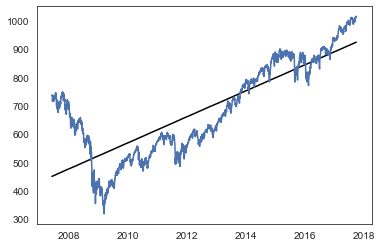

In [47]:
plt.plot(sample2['date'], regr.predict(x),color='black')
plt.plot(sample2['date'], y)

In [49]:
predicted = regr.predict(x)
actual = sample2['price']
rss = predicted - actual
rss = sum(predicted)
rss = rss **2
print(rss)

rss1 = np.sum(np.square(regr.predict(x) - y))
rss1 = rss**2
print(rss1)

average_rss = rss / bin_size
average_rss

3195605054147.9707
1.0211891662096055e+25


1229078866.9799888

In [54]:
print(predicted)
print(type(predicted))
print(actual)
print(type(actual))


[450.53375792 450.71614694 450.89853595 ... 924.1980296  924.38041861
 924.56280763]
<class 'numpy.ndarray'>
5400     736.055475
5401     737.377131
5402     738.740209
5403     734.790163
5404     728.277146
           ...     
7995    1015.582269
7996    1016.226466
7997    1013.131080
7998    1013.787431
7999    1011.534768
Name: price, Length: 2600, dtype: float64
<class 'pandas.core.series.Series'>


In [57]:
actual1 = np.array(actual)
print(actual1)

print(len(actual1))
print(len(predicted))

[ 736.05547514  737.37713101  738.74020888 ... 1013.13107986 1013.78743128
 1011.53476839]
2600
2600


<div>
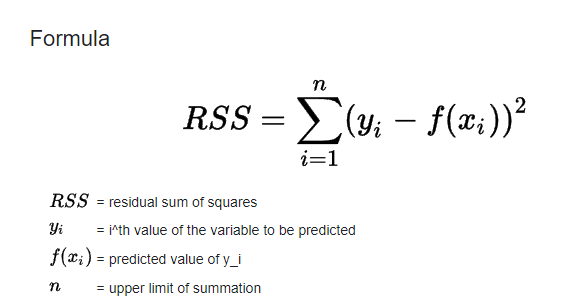
</div>

In [90]:
i = 0
diff_list = []

for i in range(len(actual1)):
    diff = actual1[i] - predicted[i]
    diff_list.append(diff)

diff_list =  [abs(i) for i in diff_list]

diff_list = pd.DataFrame(diff_list)

diff_list['date'] = sample2['date'].values
diff_list.columns = ['price', 'date']

#print(type(diff_list))
print(diff_list.describe())
diff_list.head(5)

             price
count  2600.000000
mean     76.628680
std      58.614462
min       0.003113
25%      37.001535
50%      66.637383
75%      94.855008
max     289.317401


,price,date
0,285.521717,2007-05-31
1,286.660984,2007-06-01
2,287.841673,2007-06-04
3,283.709238,2007-06-05
4,277.013832,2007-06-06


Standard deviation is 58 points, that seems usable from a range perspective. Maybe brackets could be in increments of 0.5 standard deviations. This showsthe data is very skewed towards the high values (see high mean) 

Idea: SnP Chart that changes colour as it goees through the different brackets

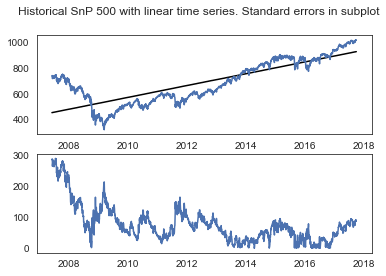

In [86]:
fig, axs = plt.subplots(2)
fig.suptitle('Historical SnP 500 with linear time series. Standard errors in subplot')
axs[0].plot(sample2['date'], regr.predict(x),color='black')
axs[0].plot(sample2['date'], y)
axs[1].plot(diff_list['date'], diff_list['price'])
#axs[1].set_xlim(0,8000)

From this, we see the biggest difference is frontloaded. We'll need to see if that distorts the analysis. In any case we onlty care about the difference at time t

Also - shows our intuition of 0.5 x standard deviation might give us a good granularity on the thresholds (in this case it would be in s

## 7 - Investing Mechanism

To do: 
- colour bands on standard deviation for visual info

Idea here is to have a script that attaches weight to buy or sell decisions such that:
- Being in the lower band of difference from the prediction adds fewer points to the "decision value"
- Points are added more quickly if you move between the bands faster
- Buy/sell weight is smaller for lower bands
- orefernce to buy over sell


#### 7.1 - Defining bands, band rules and function to check if value is in band

In [89]:
last_value = diff_list["price"].iloc[-1]
last_value

86.97196076497187

In [92]:
stdev = diff_list['price'].std() 
stdev

58.61446219082128

In [96]:
band1_bottom = 0
band1_top = 0.5 * stdev
band2_bottom = 0.5 * stdev + 0.000001
band2_top = stdev 
band3_bottom = stdev + 0.000001
band3_top = 1.5 * stdev
band4_bottom = 1.5 * stdev + 0.000001
band4_top = 2 * stdev
band5_bottom = 2 * stdev + 0.000001
band5_top = 2.5 * stdev
band6_bottom = 2.5 * stdev + 0.000001
band6_top = 3 * stdev


print(band1_bottom)
print(band1_top)
print(band2_bottom)
print(band2_top)
print(band3_bottom)
print(band3_top)
print(band4_bottom)
print(band4_top)
print(band5_bottom)
print(band5_top)
print(band6_bottom)
print(band6_top)

0
29.30723109541064
29.30723209541064
58.61446219082128
58.614463190821276
87.92169328623191
87.92169428623191
117.22892438164256
117.22892538164255
146.5361554770532
146.5361564770532
175.84338657246383


<div>
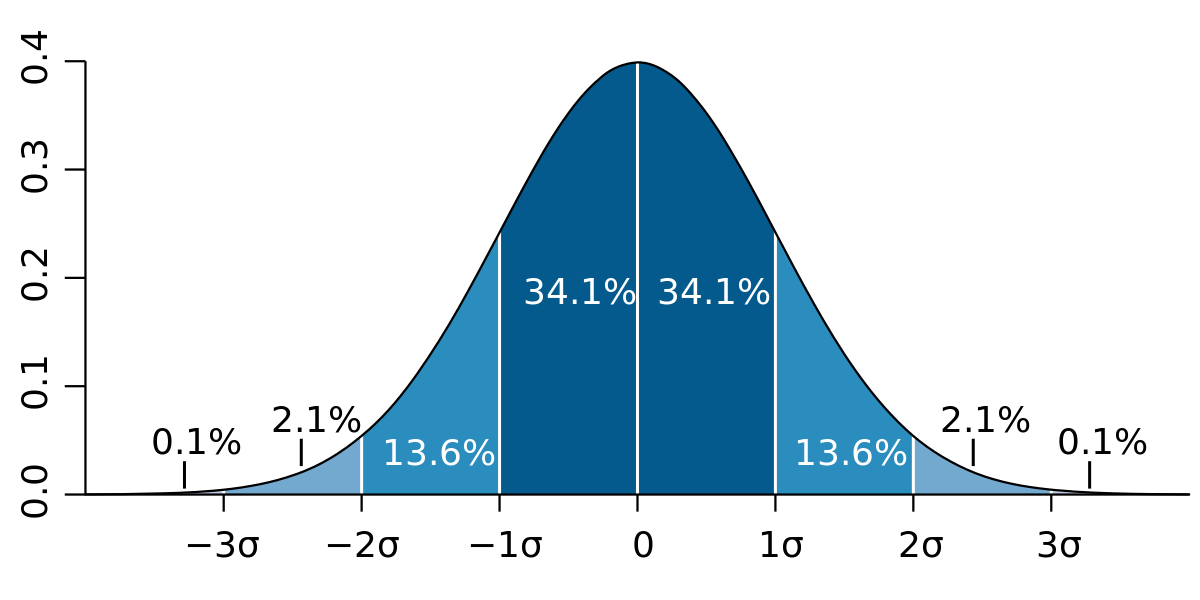
</div>

In [107]:
range(len(sample2))

range(0, 2600)

#### 7.2 - Defining function to check if it is in range

In [104]:
def check_value(price):
    if band1_bottom < price < band1_top:
        return 1
    if band2_bottom < price < band2_top:
        return 2
    if band3_bottom < price < band3_top:
        return 3
    if band4_bottom < price < band4_top:
        return 4
    if band5_bottom < price < band5_top:
        return 5
    if band6_bottom < price < band6_top:
        return 6
    if price > band6_bottom:
        return 7
    
#test = check_value(50)
#test

2

In [111]:
range_cat = []

for i in range(len(sample2)):
    price = diff_list["price"].iloc[i]
    band = check_value(price)
    range_cat.append(band)

#range_cat

sample2['range_cat'] = range_cat

sample2.head(5)

,date,price,start price,cagr,time,range_cat
5400,2007-05-31,736.055475,274.909355,6.786102,0,7
5401,2007-06-01,737.377131,274.300218,6.814669,1,7
5402,2007-06-04,738.740209,274.039159,6.834603,2,7
5403,2007-06-05,734.790163,273.894126,6.800194,3,7
5404,2007-06-06,728.277146,276.686004,6.664679,4,7


#### Defining buy/sell rules

What we want to do here is try to time the buy or sale as well as possible.

***Buy Counter***
- Anything above band 4 adds to the bucket
- 

***Weight Counter***
- Distribution and order of the values matter, with more extreme moveemnts giving us more confidence it is a goood time to buy


What is the simple version: buy everytime it hits 7 and sell everytime it hits 7

In [113]:
last_pred = diff_list["price"].iloc[-1]
last_pred

86.97196076497187

In [112]:
last_value = sample2['price'].iloc[-1]
last_value

1011.5347683930329

In [ ]:
wallet = 1000000

for i in range(len(df1)):
    temp_sample = 

In [114]:
range(len(df1))

range(0, 8192)

## Charts

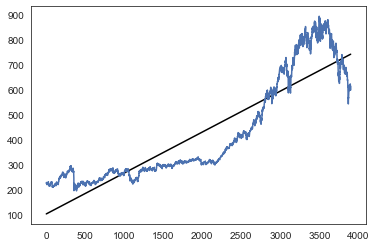

In [68]:
plt.plot(x, regr.predict(x),color='black')
plt.plot(x, y)

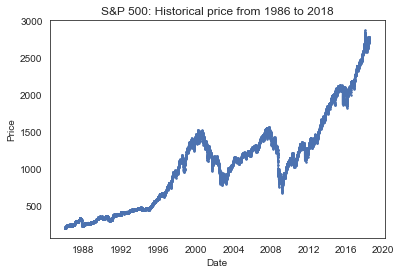

In [34]:
plt.plot(df1["close"], marker="o", ms=1.5)

# Labelling 

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("S&P 500: Historical price from 1986 to 2018")

#plt.xlim([datetime.date(1886, 1, 1), datetime.date(2018, 1, 1)])
#plt.ylim(-20,20)

plt.show()

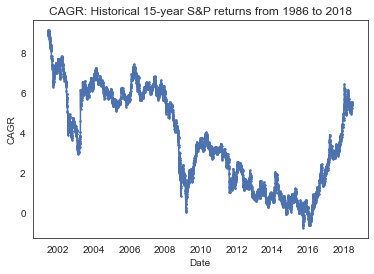

In [38]:
plt.plot(df1["cagr"], marker="o", ms=1.5)

# Labelling 

plt.xlabel("Date")
plt.ylabel("CAGR")
plt.title("CAGR: Historical 15-year S&P returns from 1986 to 2018")

#plt.xlim([datetime.date(1886, 1, 1), datetime.date(2018, 1, 1)])
#plt.ylim(-20,20)

plt.show()

## Notes

In [ ]:
#------------- creating a time series list ------------------#
#start = datetime.datetime(2020, 1, 1)
#end = datetime.datetime(2020, 12, 31)
#index = pd.date_range(start, end)
#index, len(index)